In [ ]:
!pip install --upgrade gradio

pre version gradio- 5.23.3

In [ ]:
!pip install --upgrade gradio


In [6]:
! pip install pillow

## Uploading PDf - Experimental step

In [1]:
import fitz  # PyMuPDF
import gradio as gr
from PIL import Image
import io

In [2]:
# Load PDF and convert pages to images
def load_pdf_images(pdf_path):
    doc = fitz.open(pdf_path)
    images = []
    for page_num in range(len(doc)):
        pix = doc.load_page(page_num).get_pixmap()
        img = Image.open(io.BytesIO(pix.tobytes("png")))
        images.append((img, page_num + 1))  # Store (image, page_number)
    return images

# Simulate backend action on page selection
def handle_page_selection(page_number):
    return f"Page {page_number} selected. (Ready to process on backend)"

# Simulate streaming chat
def stream_chat(message, history):
    for i in range(5):
        yield history + [[message, f"Thinking{'.' * (i+1)}"]]


In [7]:
# PDF to load
PDF_PATH = "../../../Data/pdfs_for_Vanilla_RAG/sci_bk/science G-6 E.pdf"  # Replace with your actual file
pdf_images = load_pdf_images(PDF_PATH)

In [9]:
pdf_images

[(<PIL.PngImagePlugin.PngImageFile image mode=RGB size=531x702>, 1),
 (<PIL.PngImagePlugin.PngImageFile image mode=RGB size=531x702>, 2),
 (<PIL.PngImagePlugin.PngImageFile image mode=RGB size=531x702>, 3),
 (<PIL.PngImagePlugin.PngImageFile image mode=RGB size=531x702>, 4),
 (<PIL.PngImagePlugin.PngImageFile image mode=RGB size=531x702>, 5),
 (<PIL.PngImagePlugin.PngImageFile image mode=RGB size=531x702>, 6),
 (<PIL.PngImagePlugin.PngImageFile image mode=RGB size=531x702>, 7),
 (<PIL.PngImagePlugin.PngImageFile image mode=RGB size=531x702>, 8),
 (<PIL.PngImagePlugin.PngImageFile image mode=RGB size=531x702>, 9),
 (<PIL.PngImagePlugin.PngImageFile image mode=RGB size=531x702>, 10),
 (<PIL.PngImagePlugin.PngImageFile image mode=RGB size=531x702>, 11),
 (<PIL.PngImagePlugin.PngImageFile image mode=RGB size=531x702>, 12),
 (<PIL.PngImagePlugin.PngImageFile image mode=RGB size=531x702>, 13),
 (<PIL.PngImagePlugin.PngImageFile image mode=RGB size=531x702>, 14),
 (<PIL.PngImagePlugin.PngImag

In [9]:
# Gradio UI
with gr.Blocks() as demo:
    gr.Markdown("## PDF Viewer and Chatbot")

    with gr.Row():
        # Left: PDF panel
        with gr.Column(scale=1):
            gr.Markdown("**PDF Pages** (Click to select a page)")
            selected_page = gr.Number(label="Selected Page", interactive=False)
            gallery = gr.Gallery(label="PDF Pages", show_label=False, columns=1, height=600)
            gallery.value = [img for img, _ in pdf_images]

            def on_image_click(evt: gr.SelectData):
                index = evt.index  # Index in the list of pages
                page_number = pdf_images[index][1]
                selected_page.value = page_number
                return handle_page_selection(page_number), page_number

            gallery.select(on_image_click, outputs=[gr.Textbox(label="Backend Response"), selected_page])

        # Right: Chat panel
        with gr.Column(scale=2):
            chatbot = gr.Chatbot()
            msg = gr.Textbox(label="Your Message", type = 'text')
            send_btn = gr.Button("Send")

            def respond(message, chat_history):
                return stream_chat(message, chat_history)

            send_btn.click(respond, inputs=[msg, chatbot], outputs=chatbot)
            msg.submit(respond, inputs=[msg, chatbot], outputs=chatbot)

demo.launch()


C:\Users\Lisara\AppData\Local\Temp\ipykernel_17168\1512401792.py:23: UserWarning: You have not specified a value for the `type` parameter. Defaulting to the 'tuples' format for chatbot messages, but this is deprecated and will be removed in a future version of Gradio. Please set type='messages' instead, which uses openai-style dictionaries with 'role' and 'content' keys.
  chatbot = gr.Chatbot()


* Running on local URL:  http://127.0.0.1:7861

To create a public link, set `share=True` in `launch()`.


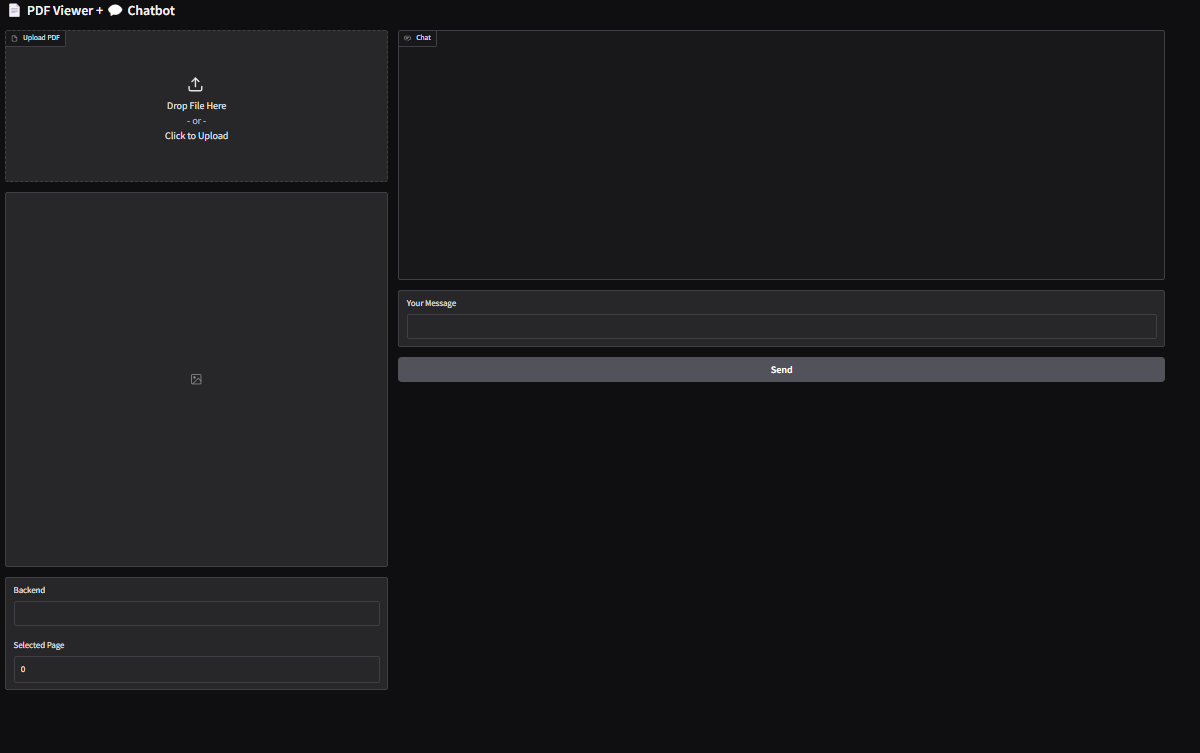

## PDF loading from backend

In [ ]:
import fitz  # PyMuPDF
import gradio as gr
from PIL import Image
import io

# Convert PDF pages to images
def pdf_to_images(pdf_bytes):
    doc = fitz.open(stream=pdf_bytes, filetype="pdf")
    images = []
    for i in range(len(doc)):
        pix = doc.load_page(i).get_pixmap(dpi=150)
        img = Image.open(io.BytesIO(pix.tobytes("png")))
        images.append((img, i + 1))
    return images

# Handle PDF upload and return gallery images
def load_pdf(file):
    try:
        pdf_bytes = file.read()
        images = pdf_to_images(pdf_bytes)
        global pdf_pages
        pdf_pages = images
        return [img for img, _ in images], gr.update(visible=False)
    except Exception as e:
        print(f"[ERROR] PDF loading failed: {e}")
        return [], gr.update(visible=True, value=f"❌ Failed to load PDF: {str(e)}")

# Handle page selection
def on_image_click(evt: gr.SelectData):
    index = evt.index
    try:
        page_number = pdf_pages[index][1]
        return f"Selected Page: {page_number}", page_number
    except Exception as e:
        print(f"[ERROR] Page selection failed: {e}")
        return "Page selection error", -1

# Dummy chat streamer
def stream_response(msg, history):
    for i in range(5):
        yield history + [[msg, f"Responding{'.' * (i+1)}"]]

# Global store
pdf_pages = []

# Build the Gradio UI
with gr.Blocks() as demo:
    gr.Markdown("## 📄 PDF Viewer + 💬 Chatbot")

    with gr.Row():
        # LEFT PANEL: PDF
        with gr.Column(scale=1):
            pdf_upload = gr.File(label="Upload PDF", file_types=[".pdf"])
            gallery = gr.Gallery(label="PDF Pages", columns=1, height=600, show_label=False)
            backend_response = gr.Textbox(label="Backend", interactive=False)
            selected_page = gr.Number(label="Selected Page", interactive=False)
            error_box = gr.Textbox(label="Errors", visible=False)

            pdf_upload.change(fn=load_pdf, inputs=pdf_upload, outputs=[gallery, error_box])
            gallery.select(fn=on_image_click, outputs=[backend_response, selected_page])

        # RIGHT PANEL: Chatbot
        with gr.Column(scale=2):
            chatbot = gr.Chatbot(label="Chat")
            msg = gr.Textbox(label="Your Message")
            send = gr.Button("Send")

            send.click(fn=stream_response, inputs=[msg, chatbot], outputs=chatbot)
            msg.submit(fn=stream_response, inputs=[msg, chatbot], outputs=chatbot)

demo.launch()


C:\Users\Lisara\AppData\Local\Temp\ipykernel_18588\781459211.py:64: UserWarning: You have not specified a value for the `type` parameter. Defaulting to the 'tuples' format for chatbot messages, but this is deprecated and will be removed in a future version of Gradio. Please set type='messages' instead, which uses openai-style dictionaries with 'role' and 'content' keys.
  chatbot = gr.Chatbot(label="Chat")


* Running on local URL:  http://127.0.0.1:7862

To create a public link, set `share=True` in `launch()`.


In [10]:
import fitz  # PyMuPDF
import gradio as gr
from PIL import Image
import io

# Load predefined PDF from backend
PDF_PATH = "../../../Data/pdfs_for_Vanilla_RAG/sci_bk/science G-6 E.pdf"  # Replace with your actual file path


In [13]:
# Convert PDF pages to images
def pdf_to_images_from_path(pdf_path):
    doc = fitz.open(pdf_path)
    images = []
    for i in range(len(doc)):
        pix = doc.load_page(i).get_pixmap(dpi=150)
        img = Image.open(io.BytesIO(pix.tobytes("png")))
        images.append((img, i + 1))
    return images

# Handle the "Load PDF" button
def handle_load_pdf():
    try:
        images = pdf_to_images_from_path(PDF_PATH)
        global pdf_pages
        pdf_pages = images
        return [img for img, _ in images], gr.update(visible=False)
    except Exception as e:
        print(f"[ERROR] Loading predefined PDF failed: {e}")
        return
# Dummy chat streamer
def stream_response(msg, history):
    for i in range(5):
        yield history + [[msg, f"Responding{'.' * (i+1)}"]]

In [14]:
# Global storage
pdf_pages = []

In [15]:
# Build Gradio UI
with gr.Blocks() as demo:
    gr.Markdown("## 📄 PDF Viewer + 💬 Chatbot")

    with gr.Row():
        # LEFT PANEL
        with gr.Column(scale=1):
            load_button = gr.Button("📂 Load PDF from backend")
            gallery = gr.Gallery(label="PDF Pages", columns=1, height=600, show_label=False)
            backend_response = gr.Textbox(label="Backend", interactive=False)
            selected_page = gr.Number(label="Selected Page", interactive=False)
            error_box = gr.Textbox(label="Errors", visible=False)

            load_button.click(fn=handle_load_pdf, outputs=[gallery, error_box])
            gallery.select(fn=on_image_click, outputs=[backend_response, selected_page])

        # RIGHT PANEL
        with gr.Column(scale=2):
            chatbot = gr.Chatbot(label="Chat")
            msg = gr.Textbox(label="Your Message")
            send = gr.Button("Send")

            send.click(fn=stream_response, inputs=[msg, chatbot], outputs=chatbot)
            msg.submit(fn=stream_response, inputs=[msg, chatbot], outputs=chatbot)

demo.launch()

C:\Users\Lisara\AppData\Local\Temp\ipykernel_17168\1704060661.py:19: UserWarning: You have not specified a value for the `type` parameter. Defaulting to the 'tuples' format for chatbot messages, but this is deprecated and will be removed in a future version of Gradio. Please set type='messages' instead, which uses openai-style dictionaries with 'role' and 'content' keys.
  chatbot = gr.Chatbot(label="Chat")


* Running on local URL:  http://127.0.0.1:7862

To create a public link, set `share=True` in `launch()`.


---

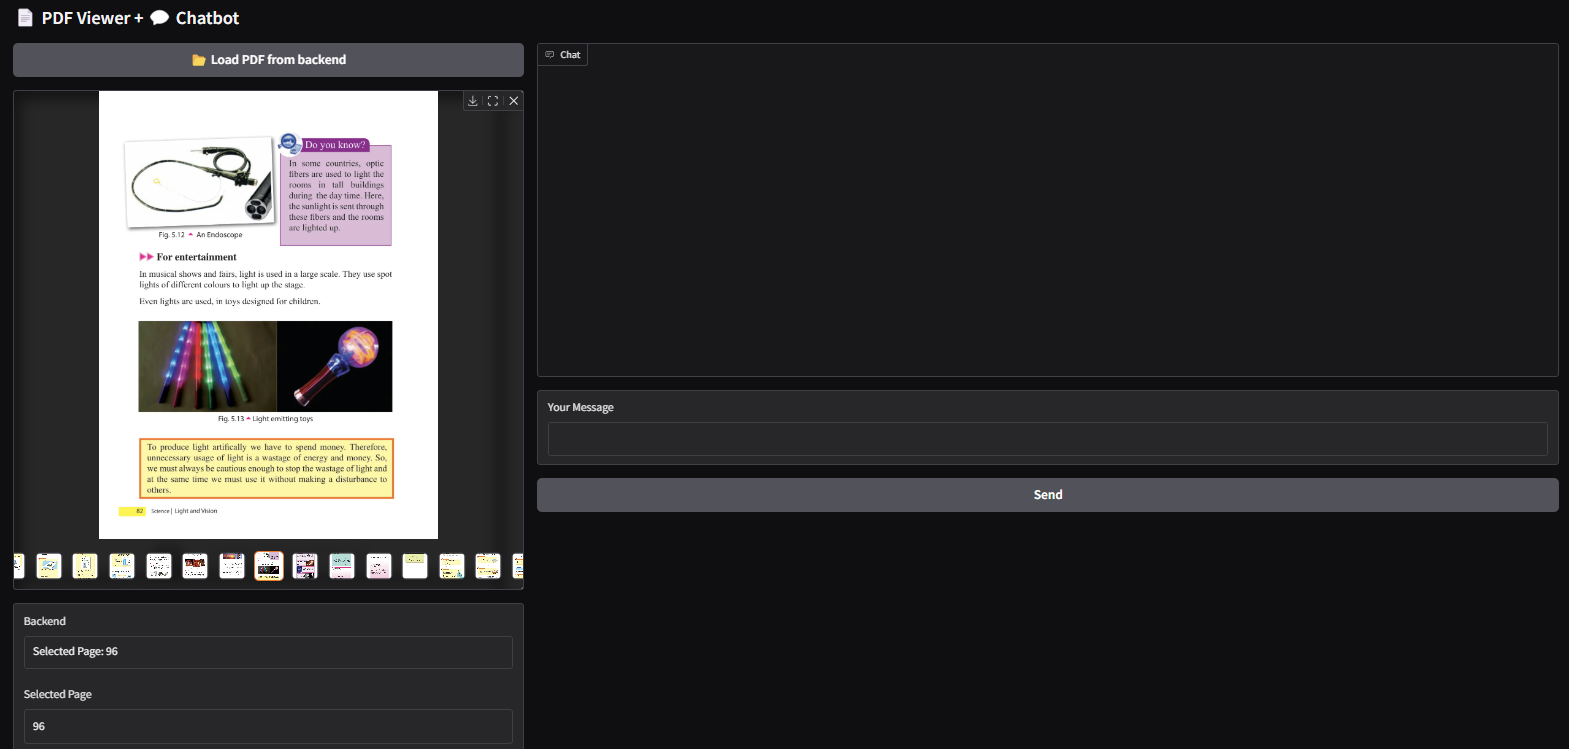

---

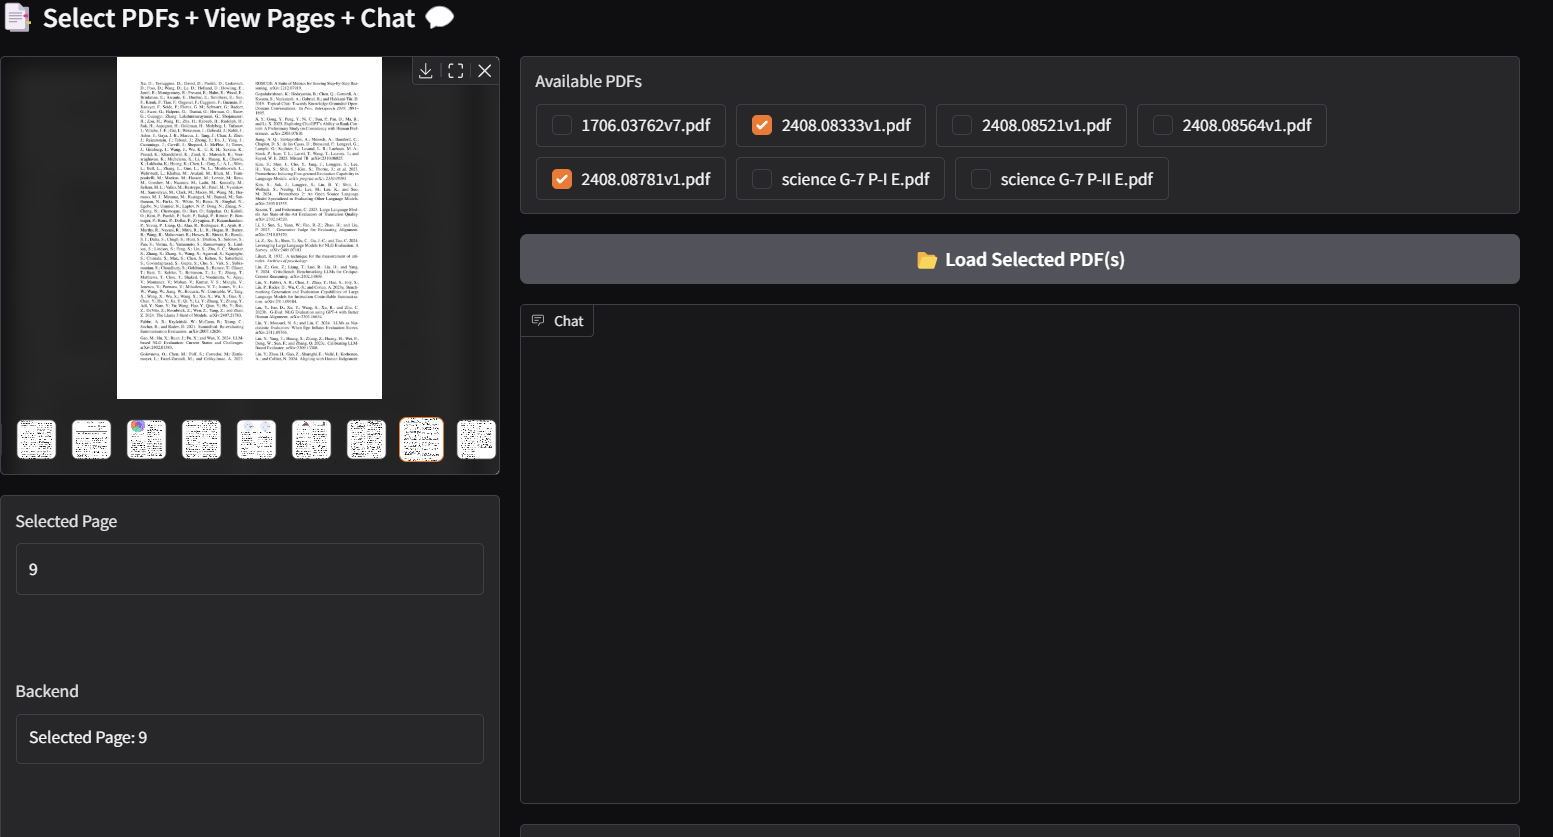

In [20]:
import os
import fitz  # PyMuPDF
import gradio as gr
from PIL import Image
import io


In [21]:

# Folder with your PDFs
PDF_DIR = "../../../Data/pdfs_for_Vanilla_RAG"
pdf_files = [f for f in os.listdir(PDF_DIR) if f.endswith(".pdf")]

# Convert selected PDF to images
def load_selected_pdf(selected_files):
    try:
        if not selected_files:
            return [], [], " No file selected"

        # Just show the first one in preview
        selected_path = os.path.join(PDF_DIR, selected_files[0])
        doc = fitz.open(selected_path)
        images = []
        for i in range(len(doc)):
            pix = doc.load_page(i).get_pixmap(dpi=120)
            img = Image.open(io.BytesIO(pix.tobytes("png")))
            images.append((img, i + 1))

        global pdf_pages
        pdf_pages = images

        # Create selection list as [0, 1, 0,...]
        binary_selection = [1 if f in selected_files else 0 for f in pdf_files]
        return [img for img, _ in images], binary_selection, ""
    except Exception as e:
        print(f"[ERROR] Loading selected PDF failed: {e}")
        return [], [], f"❌ Error: {str(e)}"

# Handle image click
def on_image_click(evt: gr.SelectData):
    index = evt.index
    try:
        page_number = pdf_pages[index][1]
        return f"Selected Page: {page_number}", page_number
    except Exception as e:
        print(f"[ERROR] Page selection failed: {e}")
        return "❌ Page selection error", -1

# Stream response
def stream_response(msg, history):
    for i in range(5):
        yield history + [[msg, f"Thinking{'.' * (i+1)}"]]

# Global state
pdf_pages = []


## Bounding box on uploaded image

In [22]:

# Build UI
with gr.Blocks(fill_height=False) as demo:
    gr.Markdown("## 📑 Select PDFs + View Pages + Chat 💬")

    with gr.Row(equal_height=True):
        # LEFT PANEL
        with gr.Column(scale=1):
            
            gallery = gr.Gallery(label="Pages", columns=1, height=300, show_label=False)
            selected_page = gr.Number(label="Selected Page", interactive=False)
            backend_response = gr.Textbox(label="Backend", interactive=False)
            backend_data = gr.Textbox(label="Binary Selection", interactive=False)
            error_box = gr.Textbox(label="Errors", visible=False)

        # RIGHT PANEL
        with gr.Column(scale=2):
            selector = gr.CheckboxGroup(choices=pdf_files, label="Available PDFs")
            load_button = gr.Button("📂 Load Selected PDF(s)")
            chatbot = gr.Chatbot(label="Chat")
            msg = gr.Textbox(label="Your Message")
            send = gr.Button("Send")
            load_button.click(
                fn=load_selected_pdf,
                inputs=[selector],
                outputs=[gallery, backend_data, error_box]
            )
            gallery.select(fn=on_image_click, outputs=[backend_response, selected_page])

            send.click(fn=stream_response, inputs=[msg, chatbot], outputs=chatbot)
            msg.submit(fn=stream_response, inputs=[msg, chatbot], outputs=chatbot)

demo.launch()


C:\Users\Lisara\AppData\Local\Temp\ipykernel_17168\787540286.py:21: UserWarning: You have not specified a value for the `type` parameter. Defaulting to the 'tuples' format for chatbot messages, but this is deprecated and will be removed in a future version of Gradio. Please set type='messages' instead, which uses openai-style dictionaries with 'role' and 'content' keys.
  chatbot = gr.Chatbot(label="Chat")


* Running on local URL:  http://127.0.0.1:7863

To create a public link, set `share=True` in `launch()`.


---

# Page segment selection

In [23]:
import gradio as gr
import fitz  # PyMuPDF
from PIL import Image
import io

import gradio as gr

ROI_coordinates = {
    'x_temp': 0,
    'y_temp': 0,
    'x_new': 0,
    'y_new': 0,
    'clicks': 0,
}


def get_select_coordinates(img, evt: gr.SelectData):
    sections = []
    # update new coordinates
    ROI_coordinates['clicks'] += 1
    ROI_coordinates['x_temp'] = ROI_coordinates['x_new']
    ROI_coordinates['y_temp'] = ROI_coordinates['y_new']
    ROI_coordinates['x_new'] = evt.index[0]
    ROI_coordinates['y_new'] = evt.index[1]
    # compare start end coordinates
    x_start = ROI_coordinates['x_new'] if (ROI_coordinates['x_new'] < ROI_coordinates['x_temp']) else ROI_coordinates['x_temp']
    y_start = ROI_coordinates['y_new'] if (ROI_coordinates['y_new'] < ROI_coordinates['y_temp']) else ROI_coordinates['y_temp']
    x_end = ROI_coordinates['x_new'] if (ROI_coordinates['x_new'] > ROI_coordinates['x_temp']) else ROI_coordinates['x_temp']
    y_end = ROI_coordinates['y_new'] if (ROI_coordinates['y_new'] > ROI_coordinates['y_temp']) else ROI_coordinates['y_temp']
    if ROI_coordinates['clicks'] % 2 == 0:
        # both start and end point get
        sections.append(((x_start, y_start, x_end, y_end), "ROI of Face Detection"))
        return (img, sections)
    else:
        point_width = int(img.shape[0]*0.05)
        sections.append(((ROI_coordinates['x_new'], ROI_coordinates['y_new'], 
                          ROI_coordinates['x_new'] + point_width, ROI_coordinates['y_new'] + point_width),
                        "Click second point for ROI"))
        return (img, sections)


with gr.Blocks() as demo:
    with gr.Row():
        input_img = gr.Image(label="Click")
        img_output = gr.AnnotatedImage(label="ROI", 
                                       color_map={"ROI of Face Detection": "#9987FF",
                                                  "Click second point for ROI": "#f44336"})
    input_img.select(get_select_coordinates, input_img, img_output)

if __name__ == '__main__':
    demo.launch(inbrowser=True)


* Running on local URL:  http://127.0.0.1:7864

To create a public link, set `share=True` in `launch()`.


In [2]:

# Load and render just the first page
def get_first_page(pdf_path):
    doc = fitz.open(pdf_path)
    page = doc.load_page(0)
    pix = page.get_pixmap(dpi=150)
    image = Image.open(io.BytesIO(pix.tobytes("png")))
    return image


In [3]:

# Handle bounding box input
def handle_bbox(image, bbox_data):
    if not bbox_data:
        return "No region selected"
    bbox = bbox_data[-1]["box"]  # [x, y, w, h]
    return f"Selected box: {bbox}"


In [24]:

# Use a real PDF path here
# PDF_PATH = "your_file.pdf"

with gr.Blocks() as demo:
    gr.Markdown("## Select a Region on PDF Page")
    
    with gr.Row():
        with gr.Column(scale=2):
            img_view = gr.Image(
                value=get_first_page(PDF_PATH),
                tool="select",  # Enables rectangle selection
                type="pil",
                label="Draw a box on the PDF page"
            )
        with gr.Column(scale=1):
            output = gr.Textbox(label="Selected Bounding Box")
            img_view.select(fn=handle_bbox, inputs=[img_view], outputs=output)

demo.launch()


TypeError: Image.__init__() got an unexpected keyword argument 'tool'

# Complete UI with bounding box pdf viewer

In [ ]:
# ../../../Data/pdfs_for_Vanilla_RAG/sci_bk/2408.08333v1.pdf

In [4]:
import gradio as gr
import fitz  # PyMuPDF
from PIL import Image
import io
import os

# Folder with your PDFs
PDF_DIR = "../../../Data/pdfs_for_Vanilla_RAG"
pdf_files = [f for f in os.listdir(PDF_DIR) if f.endswith(".pdf")]

# Global state
pdf_pages = []
roi_coords = {"x1": 0, "y1": 0, "x2": 0, "y2": 0, "clicks": 0}

# Convert selected PDF to images
def load_selected_pdf(selected_files):
    try:
        if not selected_files:
            return [], [], " No file selected"

        # Just show the first one in preview
        selected_path = os.path.join(PDF_DIR, selected_files[0])
        doc = fitz.open(selected_path)
        images = []
        for i in range(len(doc)):
            pix = doc.load_page(i).get_pixmap(dpi=120)
            img = Image.open(io.BytesIO(pix.tobytes("png")))
            images.append((img, i + 1))

        global pdf_pages
        pdf_pages = images

        # Create selection list as [0, 1, 0,...]
        binary_selection = [1 if f in selected_files else 0 for f in pdf_files]
        return [img for img, _ in images], binary_selection, ""
    except Exception as e:
        print(f"[ERROR] Loading selected PDF failed: {e}")
        return [], [], f"❌ Error: {str(e)}"

# Handle image click
def on_image_click(evt: gr.SelectData):
    index = evt.index
    try:
        page_number = pdf_pages[index][1]
        return f"Selected Page: {page_number}", page_number
    except Exception as e:
        print(f"[ERROR] Page selection failed: {e}")
        return "❌ Page selection error", -1

# Handle bounding box selection on image
def capture_roi(img, evt: gr.SelectData):
    roi_coords["clicks"] += 1
    if roi_coords["clicks"] % 2 == 1:
        roi_coords["x1"], roi_coords["y1"] = evt.index
        return img, [((evt.index[0], evt.index[1], evt.index[0]+20, evt.index[1]+20), "First Click")]
    else:
        roi_coords["x2"], roi_coords["y2"] = evt.index
        x_start = min(roi_coords["x1"], roi_coords["x2"])
        y_start = min(roi_coords["y1"], roi_coords["y2"])
        x_end = max(roi_coords["x1"], roi_coords["x2"])
        y_end = max(roi_coords["y1"], roi_coords["y2"])
        return img, [((x_start, y_start, x_end, y_end), "Selected Region")]
    
# Stream response
def stream_response(msg, history):
    for i in range(5):
        yield history + [[msg, f"Thinking{'.' * (i+1)}"]]

# Build UI
with gr.Blocks(fill_height=False) as demo:
    gr.Markdown("## 📁 Select PDFs + View Pages + Chat 💬")

    with gr.Row(equal_height=True):
        # LEFT PANEL
        with gr.Column(scale=1):
            gallery = gr.Gallery(label="Pages", columns=1, height=300, show_label=False)
            selected_page = gr.Number(label="Selected Page", interactive=False)
            backend_response = gr.Textbox(label="Backend", interactive=False)
            backend_data = gr.Textbox(label="Binary Selection", interactive=False)
            error_box = gr.Textbox(label="Errors", visible=False)
            bbox_view = gr.AnnotatedImage(label="Bounding Box", color_map={
                "Selected Region": "#4CAF50",
                "First Click": "#FFC107"
            })
        # RIGHT PANEL
        with gr.Column(scale=2):
            selector = gr.CheckboxGroup(choices=pdf_files, label="Available PDFs")
            load_button = gr.Button("📂 Load Selected PDF(s)")
            chatbot = gr.Chatbot(label="Chat")
            msg = gr.Textbox(label="Your Message")
            send = gr.Button("Send")

            load_button.click(
                fn=load_selected_pdf,
                inputs=[selector],
                outputs=[gallery, backend_data, error_box]
            )
            gallery.select(fn=on_image_click, outputs=[backend_response, selected_page])

            send.click(fn=stream_response, inputs=[msg, chatbot], outputs=chatbot)
            msg.submit(fn=stream_response, inputs=[msg, chatbot], outputs=chatbot)

demo.launch()


C:\Users\Lisara\AppData\Local\Temp\ipykernel_18936\4159858008.py:89: UserWarning: You have not specified a value for the `type` parameter. Defaulting to the 'tuples' format for chatbot messages, but this is deprecated and will be removed in a future version of Gradio. Please set type='messages' instead, which uses openai-style dictionaries with 'role' and 'content' keys.
  chatbot = gr.Chatbot(label="Chat")


* Running on local URL:  http://127.0.0.1:7861

To create a public link, set `share=True` in `launch()`.


In [45]:
import gradio as gr
import fitz  # PyMuPDF
from PIL import Image
import io
import os

# Folder with your PDFs
PDF_DIR = "../../../Data/pdfs_for_Vanilla_RAG"
pdf_files = [f for f in os.listdir(PDF_DIR) if f.endswith(".pdf")]

# Global state
pdf_pages = []
roi_coords = {"x1": 0, "y1": 0, "x2": 0, "y2": 0, "clicks": 0}

# Convert selected PDF to images
def load_selected_pdf(selected_files):
    try:
        if not selected_files:
            return [], [], " No file selected"

        selected_path = os.path.join(PDF_DIR, selected_files[0])
        doc = fitz.open(selected_path)
        images = []
        for i in range(len(doc)):
            pix = doc.load_page(i).get_pixmap(dpi=120)
            img = Image.open(io.BytesIO(pix.tobytes("png")))
            images.append((img, i + 1))

        global pdf_pages
        pdf_pages = images

        binary_selection = [1 if f in selected_files else 0 for f in pdf_files]
        return [img for img, _ in images], binary_selection, ""
    except Exception as e:
        print(f"[ERROR] Loading selected PDF failed: {e}")
        return [], [], f"❌ Error: {str(e)}"

# Handle image click
def on_image_click(evt: gr.SelectData):
    index = evt.index
    try:
        page_number = pdf_pages[index][1]
        image = pdf_pages[index][0]
        return f"Selected Page: {page_number}", page_number, image
    except Exception as e:
        print(f"[ERROR] Page selection failed: {e}")
        return "❌ Page selection error", -1, None

# Handle bounding box selection on image
def capture_roi(img, evt: gr.SelectData):
    roi_coords["clicks"] += 1
    if roi_coords["clicks"] % 2 == 1:
        roi_coords["x1"], roi_coords["y1"] = evt.index
        return img, [((evt.index[0], evt.index[1], evt.index[0]+20, evt.index[1]+20), "First Click")]
    else:
        roi_coords["x2"], roi_coords["y2"] = evt.index
        x_start = min(roi_coords["x1"], roi_coords["x2"])
        y_start = min(roi_coords["y1"], roi_coords["y2"])
        x_end = max(roi_coords["x1"], roi_coords["x2"])
        y_end = max(roi_coords["y1"], roi_coords["y2"])
        return img, [((x_start, y_start, x_end, y_end), "Selected Region")]

# Stream response
def stream_response(msg, history):
    for i in range(5):
        yield history + [[msg, f"Thinking{'.' * (i+1)}"]]

# Build UI
with gr.Blocks(fill_height=False) as demo:
    gr.Markdown("## 📁 Select PDFs + View Pages + Bounding Box + Chat 💬")

    with gr.Row(equal_height=True):
        # LEFT PANEL
        with gr.Column(scale=1):
            gallery = gr.Gallery(label="Pages", columns=1, height=300, show_label=False)
            selected_page = gr.Number(label="Selected Page", interactive=False)
            backend_response = gr.Textbox(label="Backend", interactive=False)
            backend_data = gr.Textbox(label="Binary Selection", interactive=False)
            error_box = gr.Textbox(label="Errors", visible=False)
            bbox_view_image = gr.AnnotatedImage(label="Bounding Box", color_map={
                "Selected Region": "#4CAF50",
                "First Click": "#FFC107"
            })

        # RIGHT PANEL
        with gr.Column(scale=2):
            selector = gr.CheckboxGroup(choices=pdf_files, label="Available PDFs")
            load_button = gr.Button("📂 Load Selected PDF(s)")
            chatbot = gr.Chatbot(label="Chat")
            msg = gr.Textbox(label="Your Message")
            send = gr.Button("Send")

            load_button.click(
                fn=load_selected_pdf,
                inputs=[selector],
                outputs=[gallery, backend_data, error_box]
            )

            gallery.select(fn=on_image_click, outputs=[backend_response, selected_page, bbox_view_image])
            # Note: Visibility must be controlled dynamically using a function and returned as output if needed
            bbox_view.select(fn=capture_roi, inputs=bbox_view, outputs=bbox_view)

            send.click(fn=stream_response, inputs=[msg, chatbot], outputs=chatbot)
            msg.submit(fn=stream_response, inputs=[msg, chatbot], outputs=chatbot)

demo.launch()

C:\Users\Lisara\AppData\Local\Temp\ipykernel_17168\460697629.py:89: UserWarning: You have not specified a value for the `type` parameter. Defaulting to the 'tuples' format for chatbot messages, but this is deprecated and will be removed in a future version of Gradio. Please set type='messages' instead, which uses openai-style dictionaries with 'role' and 'content' keys.
  chatbot = gr.Chatbot(label="Chat")


* Running on local URL:  http://127.0.0.1:7882

To create a public link, set `share=True` in `launch()`.


Traceback (most recent call last):
  File "c:\Users\Lisara\anaconda3\envs\IRPenv\Lib\site-packages\gradio\queueing.py", line 625, in process_events
    response = await route_utils.call_process_api(
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Lisara\anaconda3\envs\IRPenv\Lib\site-packages\gradio\route_utils.py", line 322, in call_process_api
    output = await app.get_blocks().process_api(
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Lisara\anaconda3\envs\IRPenv\Lib\site-packages\gradio\blocks.py", line 2147, in process_api
    data = await self.postprocess_data(block_fn, result["prediction"], state)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Lisara\anaconda3\envs\IRPenv\Lib\site-packages\gradio\blocks.py", line 1939, in postprocess_data
    prediction_value = block.postprocess(prediction_value)
                       ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Lisara\anaconda3\env